# Random Forest Tutorial

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import tree 

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# For tokenization
import nltk
# For converting words into frequency counts
from sklearn.feature_extraction.text import CountVectorizer

* Every tree in a random forest uses a different bootstrap sample of the training set.
* To train a tree in a random forest, a first randomly select a subset of features. 
* A reasonable implementation for random forests would be for each tree to "vote".

## Data and preprocessing

I am going to do some sentiment analysis with the [IMDB movie review data set](https://www.kaggle.com/utathya/imdb-review-dataset). The task is to assign positive or negative label to a text based on the sentiment or attitude expressed in it. For speed, I will subset the dataset to 5000 samples.

In [44]:
# Read IMDB movie reviews into a pandas DataFrame
imdb_df = pd.read_csv('data/imdb_master.csv', encoding = "ISO-8859-1")
imdb_df.head()

,Unnamed: 0,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [45]:
# Only keep the reviews with pos and neg labels
imdb_df = imdb_df[imdb_df['label'].str.startswith(('pos','neg'))]

# Sample 5000 rows from the dataframe. 
imdb_df_subset = imdb_df.sample(n = 5000)

# Convert a collection of text documents to a matrix of token presence or absence. 
# We are using only 5000 words, English stopwords, and tokenization is done using
# nltk, which is a popular text processing library.
movie_vec = CountVectorizer(max_features=5000, 
                            tokenizer=nltk.word_tokenize, 
                            stop_words='english', 
                            binary = True)
# Create X and y
X_imdb = movie_vec.fit_transform(imdb_df_subset['review'])
y_imdb = imdb_df_subset.label

In [53]:
imdb_df_subset.head()

,Unnamed: 0,type,review,label,file
3187,3187,test,This might not have been as horribly bad as it...,neg,1619_3.txt
20652,20652,test,Count Laszlo (Ralph Fiennes) has just been tra...,pos,6088_10.txt
8487,8487,test,What do you get when you put Lou Diamond Phili...,neg,638_1.txt
3162,3162,test,"Alright, so not every Australian movie is all ...",neg,1597_1.txt
37588,37588,train,"OK, let's get this clear. I'm really not into ...",pos,1007_10.txt


## Random Forests

### Steps that need to be taken in Scikit Learn

1. Split `X_imdb` into train (80%) and test (20%). 
2. Train a [random forest classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) on the train portion.
4. Score the classifier on the test portion and compare the results with the training score.

In [20]:
from sklearn.ensemble import RandomForestClassifier

In [21]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_imdb, 
                                                    y_imdb, 
                                                    test_size = 0.20, 
                                                    random_state = 12)

In [22]:
random_forest = RandomForestClassifier(n_estimators = 100)
random_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [23]:
random_forest.score(X_test, y_test)

0.825

The accuracy of the random forest classifier is very high when using 100 trees.  

## What makes a good feature to our trees?

We are setting the number of trees we are interested in, and we may be able to define also the depth per tree. But what are the words that are making the splits? The previous model uses GINI coefficient. GINI is a measure of homogeneity, just as entropy. GINI however, is less computationally expensive. It lets us know how often a randomly chosen object from the set is labled incorrectly. It is measured from 0 to 0.5; 0 being that our data is more homogeneous. 

Let's see for our random forest what features are the ones that help us have best divisions. Can I improve this? 

feature_names = movie_vec.get_feature_names()

In [25]:
random_forest.n_features_

5000

In [40]:
feature_importance = random_forest.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())


In [60]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(feature_names, feature_importance):
    feats[feature] = importance #add the name/value pair 

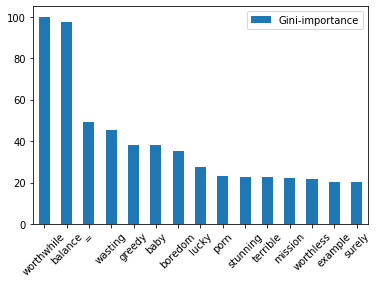

In [68]:
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending=False)[:15].plot(kind='bar', rot=45)


Although there's words such as `worthwhile` and `boredom` that can be very helpful, I can see that `=` wasn't removed during the tokenization and yet, it has a large gini index, making it a decision maker on the game! I believe this symbol needs to be removed. 

### Tuning hyperparameters

1. How many trees should I use? 
2. Run a dictionary to report test and train scores for each value of n_estimators. 
3. Consider if this is under or overfitting.

In [10]:
n_estimators_dict = {'n_estimators':[], 'train_score':[], 'test_score':[]}

# Jumping every 5 trees to speed up process.
for n_est in range(1, 100, 5):
    random_forest = RandomForestClassifier(n_estimators = n_est)
    random_forest.fit(X_train, y_train)
    
    train_score = random_forest.score(X_train, y_train)        
    test_score = random_forest.score(X_test, y_test)    

    n_estimators_dict['n_estimators'].append(n_est)    
    n_estimators_dict['train_score'].append(train_score)
    n_estimators_dict['test_score'].append(test_score)
n_estimators_df = pd.DataFrame(n_estimators_dict)
n_estimators_df        

,n_estimators,train_score,test_score
0,1,0.86050,0.672
1,6,0.97350,0.721
2,11,0.99600,0.768
3,16,0.99925,0.778
4,21,0.99950,0.783
5,26,1.00000,0.796
6,31,0.99975,0.806
7,36,1.00000,0.795
8,41,1.00000,0.814
9,46,1.00000,0.819


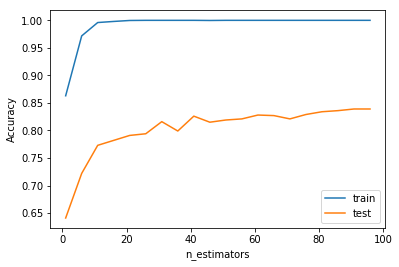

In [11]:
plt.plot(n_estimators_dict['n_estimators'], n_estimators_dict['train_score'], label = 'train')
plt.plot(n_estimators_dict['n_estimators'], n_estimators_dict['test_score'], label = 'test')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

For the `n_estimators` hyperparameter, the training accuracy reaches to 1.0 for n_estimators > 31. The test accuracy more or less starts plateauing at this point. After 31, some models could be overfitting as their test_scores decrease.

Now I want to see how deep should each tree go. I'll try with trees from 1 stump to 40 levels. 

In [11]:
max_depth_dict = {'depth':[], 'train_score':[], 'test_score':[]}

for depth in range(1, 40, 2):
    random_forest = RandomForestClassifier(n_estimators = 20, max_depth = depth)
    random_forest.fit(X_train, y_train)
    
    train_score = random_forest.score(X_train, y_train)        
    test_score = random_forest.score(X_test, y_test)    

    max_depth_dict['depth'].append(depth)        
    max_depth_dict['train_score'].append(train_score)
    max_depth_dict['test_score'].append(test_score)    
    
max_depth_df = pd.DataFrame(max_depth_dict)
max_depth_df

,depth,train_score,test_score
0,1,0.64675,0.622
1,3,0.72675,0.719
2,5,0.78000,0.714
3,7,0.82775,0.780
4,9,0.84550,0.775
5,11,0.86425,0.766
6,13,0.88875,0.779
7,15,0.90650,0.787
8,17,0.92700,0.777
9,19,0.93200,0.787


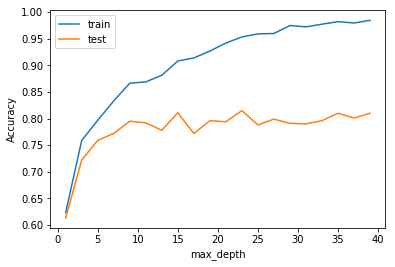

In [13]:
plt.plot(max_depth_dict['depth'], max_depth_dict['train_score'], label = 'train')
plt.plot(max_depth_dict['depth'], max_depth_dict['test_score'], label = 'test')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

For the `max_depth` hyperparameter, the training accuracy keeps increasing but the test accuracy plateaus after max_depth = 11 indicating overfitting. 

**Some advantages of random forests include**
1. Powerful and a great classifier. 
2. Predictions are faster than $k$-NN 

**Disdvantages of random forests**
1. Slow training.

However, how much randomness is there really in **random** forests? Do the results change drastically if we re-fit a forest using the same data and same hyperparameters? Should that be that worrying?

In [18]:
train_accuracies = []
test_accuracies = []

for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(X_imdb, y_imdb, test_size = 0.20)
    random_forest = RandomForestClassifier(n_estimators=5, max_depth = 100)
    random_forest.fit(X_train, y_train)
    train_accuracies.append(random_forest.score(X_train, y_train))    
    test_accuracies.append(random_forest.score(X_test, y_test))

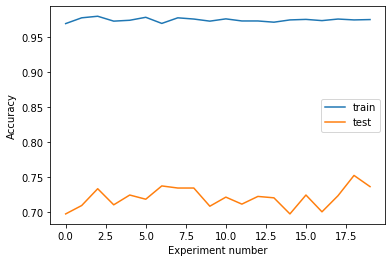

In [19]:
plt.plot(range(20), train_accuracies, label = 'train')
plt.plot(range(20), test_accuracies, label = 'test')
plt.xlabel('Experiment number')
plt.ylabel('Accuracy')
plt.legend()
plt.show()